In [29]:

import numpy as np 
from matplotlib import pyplot as plt

# 采用交错网格
def init_con(nx, ny, len_x=2, len_y=2):
    dx = len_x / (nx - 1)
    dy = len_y / (ny - 1)
    u = np.zeros((ny, nx + 1)) # 交错网格
    v = np.zeros((ny + 1, nx)) # 交错网格
    p = np.ones((ny, nx))
    return u, v, p, dx, dy


class PrjMethod(object):
    def __init__(self, u, v, p, mu, dx, dy, dt=0.001, max_iter=10000, epsion=1e-10):
        self.u = u
        self.v = v
        self.p = p
        self.mu = mu
        self.dx = dx
        self.dy = dy
        self.dt = dt
        self.max_iter= max_iter
        self.epsion= epsion
        self.rho = 1000
    
    # 速度3阶迎风格式(对流项)
    def __partial_var(self, var, is_pos):
        par_var_x = np.zeros_like(var)
        par_var_y = np.zeros_like(var)
        if  is_pos:
            par_var_x[:, 2:-1] = (2 * var[:, 3:] + 3 * var[:, 2:-1] -
                                     6 * var[:, 1:-2] + var[:, 0:-3])/6/self.dx
            par_var_y[2:-1, :] = (2 * var[3:, :] + 3 * var[2: -1, :] -
                                     6 * var[1:-2, :] + var[0:-3, :])/6/self.dy
        else:
            par_var_x[:, 1:-2] = (-1 * var[:, 3:] + 6 * var[:, 2:-1] -
                                3 * var[:, 1:-2] -2 * var[:, 0:-3])/6/self.dx
            par_var_y[1:-2, :] = (-1 * var[3:, :] + 6 * var[2: -1, :] -
                                3 * var[1:-2, :] -2 * var[0:-3, :])/6/self.dy
        return par_var_x, par_var_y
            

    # 压强2阶中心差分
    def __partial_pressure(self):
        p_press_x = np.zeros_like(self.p)
        p_press_y = np.zeros_like(self.p)
        p_press_x[1:-1, 1:-1] = (self.p[1:-1, 2:] - self.p[1:-1, 1:-1])/self.dx
        p_press_y[1:-1, 1:-1] = (self.p[2:, 1:-1] - self.p[1:-1, 1:-1])/self.dy
        return p_press_x, p_press_y
    # 扩散项压强,二阶导数
    def __partial2_pressure(self, p):
        par2_px = np.zeros_like(p)
        par2_py = np.zeros_like(p)
        par2_px[1:-1, 2:-1] = (2 * p[1:-1, 3:] + 3 * p[1:-1, 2:-1] -
                                 6 * p[1:-1, 1:-2] + p[1:-1, 0:-3])/6/self.dx
        par2_py[2:-1, 1:-1] = (2 * p[3:, 1:-1] + 3 * p[2: -1, 1:-1] -
                                 6 * p[1:-2, 1:-1] + p[0:-3, 1:-1])/6/self.dy
        # par2_px[1:-1, 1:-1] = (p[1:-1, 2:] - 2 * p[1:-1, 1:-1] + p[1:-1, 0:-2])/self.dx/self.dx
        # par2_py[1:-1, 1:-1] = (p[2:, 1:-1] - 2 * p[1:-1, 1:-1] + p[0:-2, 1:-1])/self.dy/self.dy
        return par2_px, par2_py

    # 扩散项2阶中心差分(非压强)
    def __partial2_var(self, var):
        par2_var_x = np.zeros_like(var)
        par2_var_y = np.zeros_like(var)
        par2_var_x[1:-1, 1:-1] = (var[1:-1, 2:] - 2 * var[1:-1, 1:-1] + var[1:-1, 0:-2])/self.dx/self.dx
        par2_var_y[1:-1, 1:-1] = (var[2:, 1:-1] - 2 * var[1:-1, 1:-1] + var[0:-2, 1:-1])/self.dy/self.dy
        return par2_var_x, par2_var_y
        
    def __get_var_star(self, var):
       p_var_x_pos, p_var_y_pos = self.__partial_var(var, True) 
       p_var_x_neg, p_var_y_neg = self.__partial_var(var, False) 
       convec = 0.5 * (self.u + np.abs(self.u)) * p_var_x_pos + 0.5 * (self.u - np.abs(self.u)
                ) * p_var_x_neg + 0.5 * (self.v + np.abs(self.v)) * p_var_y_pos + 0.5 * (self.v -
                np.abs(self.v)) * p_var_y_neg
       par2_var_x, par2_var_y = self.__partial2_var(var)
       var_star = var + self.dt * ((par2_var_x + par2_var_y) * self.mu - convec)
       return var_star
    
    def __get_V_star(self):
        u_star = self.__get_var_star(self.u)
        v_star = self.__get_var_star(self.v)
        return u_star, v_star
    
    def __is_converged(self, delta):
        error = np.linalg.norm(delta, ord=np.inf)
        # print(error)
        if error < self.epsion:
            return True
        return False
        
    # 求解Poisson方程,Jacobi迭代
    def __calc_p(self, u_star, v_star):
        par_u_star_x, _ = self.__partial_var(u_star, True)
        _, par_v_star_y = self.__partial_var(v_star, True)
        right_item = self.rho * (par_u_star_x + par_v_star_y) / self.dt
        
        is_converged = False
        p_ini = np.zeros_like(self.p)
        while not is_converged:
            p1 = np.zeros_like(p_ini)
            p2 = np.zeros_like(p_ini)
            p_update = np.zeros_like(p_ini)
            p1[1:-1, 1:-1] = self.dy * self.dy * (p_ini[1:-1, 2:] + p_ini[1:-1, 0:-2])
            p2[1:-1, 1:-1] = self.dx * self.dx * (p_ini[2:, 1:-1] + p_ini[0:-2, 1:-1])
            p_update[1:-1, 1:-1] = (p1[1:-1, 1:-1] + p2[1:-1, 1:-1] - right_item[1:-1, 1:-1] * self.dx * self.dx * self.dy * self.dy)/(
                2 * self.dx * self.dx + 2 * self.dy * self.dy)
            p_update[0, :] = 0
            p_update[1, :] = p_update[0, :]
            p_update[-1,:] = p_update[-2, :]
            p_update[:, -1] = p_update[:, -2]
            p_update[:, 0] = p_update[:, 1]
            delta = p_update - p_ini
            # v1, v2 = self.__partial2_pressure(p_update)
            # delta = v1 + v2 - right_item
            is_converged = self.__is_converged(delta)
            p_ini = p_update
        self.p = p_update
        return
        
    def __step_V(self):
        u_star, v_star = self.__get_V_star()
        self.__calc_p(u_star, v_star)
        p_pressure_x, p_pressure_y = self.__partial_pressure()
        self.u[1:-1, 1:-1] = u_star[1:-1, 1:-1] - self.dt * p_pressure_x[1:-1, 1:-1]/self.rho
        self.u[0, :] = 2
        # self.u[-1, :] = 0
        self.u[1:-1, 0] = -self.u[1:-1, 1]
        self.u[1:-1, -1] = -self.u[1:-1, -2]
        self.v[1:-1, 1:-1] = v_star[1:-1, 1:-1] - self.dt * p_pressure_y[1:-1, 1:-1]/self.rho
        self.v[0, :] = -self.v[1, :]
        self.v[-1, :] = -self.v[-2, :]
        # self.v[1:-1, 0] = 0
        # self.v[1:-1, -1] = 0
        return
        
    def get_solu(self):
        for i in range(self.max_iter):
            old_u = self.u.copy()
            old_v = self.v.copy()
            self.__step_V()
            delta_u = old_u - self.u
            delta_v = old_v - self.v
            print('第{}次迭代'.format(i))
            if self.__is_converged(delta_u) & self.__is_converged(delta_v):
                return
        print("Not converged after {} iterator!".format(self.max_iter))

        return -1


第0次迭代
第1次迭代
第2次迭代
第3次迭代
第4次迭代
第5次迭代
第6次迭代
第7次迭代
第8次迭代
第9次迭代
Not converged after 10 iterator!


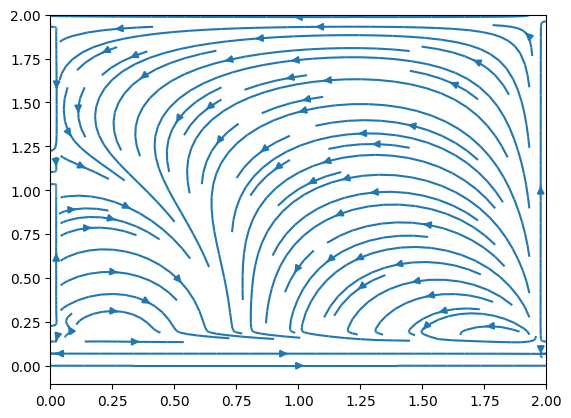

In [30]:

# 生成网格存储
u, v, p, dx, dy = init_con(41, 41)
u[0, :] = 2
re = 200
mu = 2 * 2 / re
prjmethod = PrjMethod(u, v, p, mu, dx, dy, dt=0.001, max_iter=10)
prjmethod.get_solu()


fig = plt.figure()
ax = fig.add_subplot(111)
x = np.linspace(0, 2, 41, endpoint=True)
y = np.linspace(0, 2, 41, endpoint=True)
X, Y = np.meshgrid(x, y)
ax.streamplot(X, Y, prjmethod.u, prjmethod.v)

In [10]:
prjmethod.v

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.42477262e-04,  2.29666791e-03,
         9.82488572e-04,  1.73748224e-05, -4.77399492e-04,
        -7.35212136e-04, -8.76447946e-04, -9.61253835e-04,
        -1.01945868e-03, -1.06476082e-03, -1.09943438e-03,
        -1.11654828e-03, -1.09349583e-03, -1.00181170e-03,
        -7.43025715e-04, -2.98007556e-04,  9.05361871e-04,
         2.19459519e-03,  8.18310852e-03,  0.00000000e+00],
       [ 0.00000000e+00, -2.83089197e-04,  8.66162789e-04,
         7.01505597e-04,  1.32701258e-04, -3.29797855e-04,
        -6.28666112e-04, -8.09371202e-04, -9.17713293e

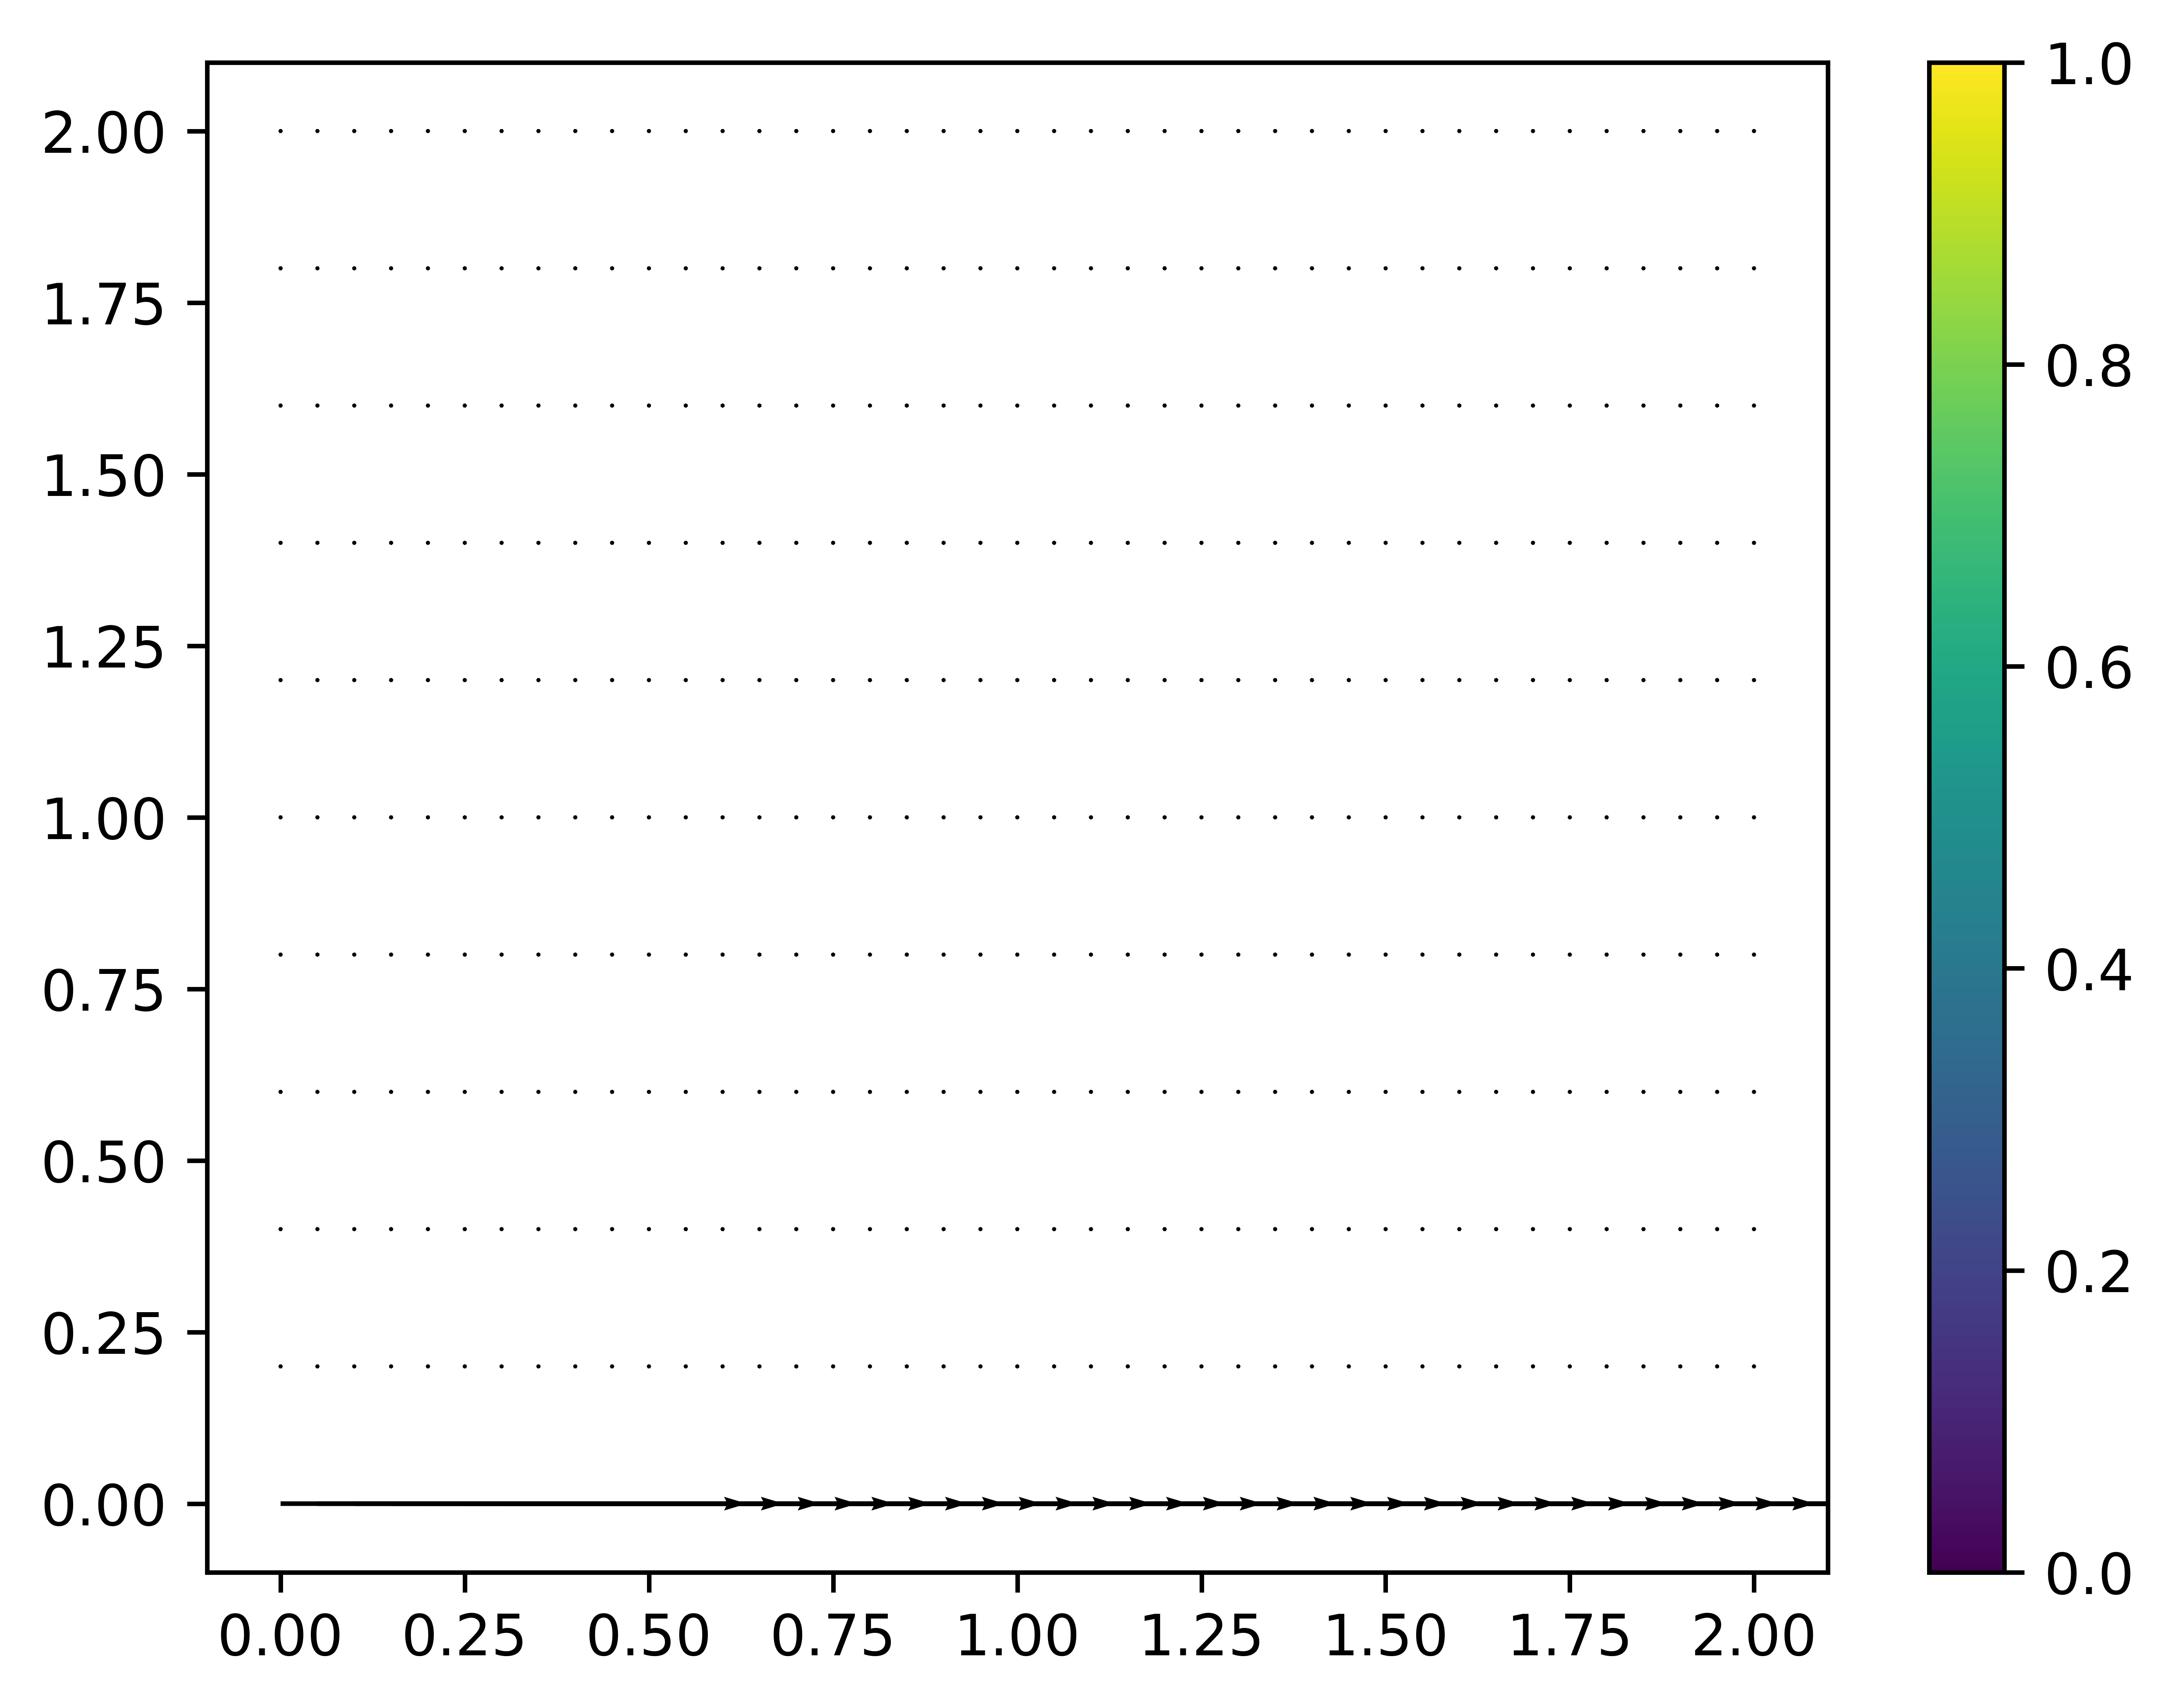

In [28]:

fig = plt.figure(dpi=1000)
ax = fig.add_subplot(111)
x = np.linspace(0, 2, 41, endpoint=True)
y = np.linspace(0, 2, 41, endpoint=True)
X, Y = np.meshgrid(x, y)
de = ax.quiver(X[::4], Y[::4], prjmethod.u[::4], prjmethod.v[::4])
fig.colorbar(de)

In [11]:
prjmethod.u

array([[ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00],
       [ 0.00000000e+00,  2.08699877e-01,  2.47134612e-01,
         2.54157258e-01,  2.53880176e-01,  2.55564243e-01,
         2.48035733e-01,  2.63927549e-01,  2.15758803e-01,
         3.39228086e-01,  0.00000000e+00],
       [ 0.00000000e+00, -9.80275279e-02, -1.11403435e-01,
        -1.07377251e-01, -1.03867914e-01, -9.99084736e-02,
        -9.97985741e-02, -8.33360135e-02, -9.23228495e-02,
         4.43917378e-03,  0.00000000e+00],
       [ 0.00000000e+00, -1.15885230e-01, -1.34149795e-01,
        -1.32167163e-01, -1.26589284e-01, -1.18897947e-01,
        -1.10631778e-01, -9.25138989e-02, -7.52350140e-02,
        -1.71212704e-02,  0.00000000e+00],
       [ 0.00000000e+00, -1.01411320e-01, -1.18291336e-01,
        -1.16653150e-01, -1.09738152e-01, -9.94891706e-02,
  

In [18]:
prjmethod.v

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -5.59743427e-04,  3.56655450e-03,
         2.95348891e-03,  2.62574688e-03,  3.03756359e-03,
         3.94703296e-03,  6.07417494e-03,  8.17338017e-03,
         1.64079889e-02,  0.00000000e+00],
       [ 0.00000000e+00, -5.42822859e-04,  1.88710817e-03,
         2.81672644e-03,  3.21632969e-03,  3.90458610e-03,
         4.98544309e-03,  6.93492093e-03,  8.86156165e-03,
         1.27743877e-02,  0.00000000e+00],
       [ 0.00000000e+00, -4.46387582e-04,  9.04098870e-04,
         2.10528767e-03,  2.95689384e-03,  3.79092885e-03,
         4.77249497e-03,  6.11340095e-03,  7.40600226e-03,
         8.92511202e-03,  0.00000000e+00],
       [ 0.00000000e+00, -3.51650108e-04,  5.35473219e-04,
         1.54096955e-03,  2.42911061e-03,  3.24385457e-03,
  